In [2]:
import xarray as xr
import numpy as np
import functions
import matplotlib.pyplot as plt

In [3]:
datadir = '/projects/NS9600K/astridbg/arctic-cld-feedbacks/data/other_cloud_vars/'

## Regrid vertical variables to pressure levels

### Hybrid sigma coordinates at interfaces

In [ ]:
savedir = datadir+'regridded_interface_last30yrs/'
exp = 'abrupt-0_5xCO2'
tslice = slice('2040-01-01', '2069-12-31')
var_list = ['TH']
regrid_vars = ['hyai', 'hybi', 'PS', 'P0']

files = []
for var in var_list+regrid_vars:
    files.append(datadir+var+'_'+exp+'.nc')
ds_i = xr.open_mfdataset(files)

ds_slice = ds_i.sel(time=tslice)

var_list = ['TH']
# Regrid timesliced data
for var in var_list:
    var_da = functions.regrid_to_pressure_interfaces(ds_slice,var)
    ds_slice[var] = var_da[var]

ds_slice = ds_slice.drop_vars(['hyai', 'hybi', 'P0', 'PS'])
ds_slice.to_netcdf(savedir+exp+'.nc')

In regrid_to_pressure atf.function. Regridding TH to pressure levels


### Hybrid sigma coordinates at midpoints

In [ ]:
savedir = datadir+'regridded_midpoint_last30yrs/'
exp = 'abrupt-0_5xCO2'
tslice = slice('2040-01-01', '2069-12-31')
var_list = ['CLOUD', 'RELHUM', 'Q', 'T']
regrid_vars = ['hyam', 'hybm', 'PS', 'P0']

files = []
for var in var_list+regrid_vars:
    files.append(datadir+var+'_'+exp+'.nc')
ds_i = xr.open_mfdataset(files)

ds_slice = ds_i.sel(time=tslice)

# Regrid timesliced data
for var in var_list:
    var_da = functions.regrid_to_pressure(ds_slice,var)
    ds_slice[var] = var_da[var]

ds_slice = ds_slice.drop_vars(['hyam', 'hybm', 'P0', 'PS'])
ds_slice.to_netcdf(savedir+exp+'.nc')

## Open variables for analysis

In [4]:
filedir = datadir+'regridded_midpoint_last30yrs/'
exp_list = ['piClim', 'abrupt-2xCO2', 'abrupt-4xCO2']
Arctic_lim = 60

ds_list = []
for exp in exp_list:
    files = filedir+exp+'_old.nc'
    ds_i = xr.open_dataset(files)
    ds_list.append(ds_i.sel(lat=slice(Arctic_lim, 90)))

ds = xr.concat(ds_list, dim='co2_conc')

In [9]:
filedir = datadir+'regridded_interface_last30yrs/'
exp_list = ['piClim', 'abrupt-2xCO2', 'abrupt-4xCO2']
Arctic_lim = 60

ds_list = []
for exp in exp_list:
    files = filedir+exp+'.nc'
    ds_i = xr.open_dataset(files)
    ds_list.append(ds_i.sel(lat=slice(Arctic_lim, 90)))

ds_if = xr.concat(ds_list, dim='co2_conc')

## Create regional masks

In [5]:
landmask = xr.open_dataarray(datadir+'LANDFRAC_piClim.nc')
landmask = landmask.isel(time=0)
oceanmask = 1-landmask

In [7]:
maskdir = '/nird/projects/NS9600K/astridbg/arctic-cld-feedbacks/data/'
tslice = slice('2040-01-01', '2069-12-31')

ds_masks_piClim = xr.open_dataset(maskdir+'N1850_f19_tn14_noresm2_3_slf_output_20250529.camextra.concatfiles.nc')
ds_masks_4xCO2 = xr.open_dataset(maskdir+'N1850_f19_tn14_noresm2_3_slf_output_4xCO2_20250529.camextra.concatfiles.nc')

# Fix time stamp
ds_masks_piClim = functions.fix_cam_time(ds_masks_piClim)
ds_masks_4xCO2 = functions.fix_cam_time(ds_masks_4xCO2)

icemask_piClim = ds_masks_piClim['ICEFRAC'].sel(time=tslice).groupby('time.season').mean('time')
icemask_4xCO2 = ds_masks_4xCO2['ICEFRAC'].sel(time=tslice).groupby('time.season').mean('time')

oceanmask_season = xr.broadcast(oceanmask, icemask_piClim.season)[0]
openocean_piClim = oceanmask_season - icemask_piClim
openocean_4xCO2 = oceanmask_season - icemask_4xCO2

## Create seasonal means

In [8]:
ds_seasons = ds.groupby('time.season').mean('time')
ds_if_seasons = ds_if.groupby('time.season').mean('time')

NameError: name 'ds_if' is not defined

## Difference plots

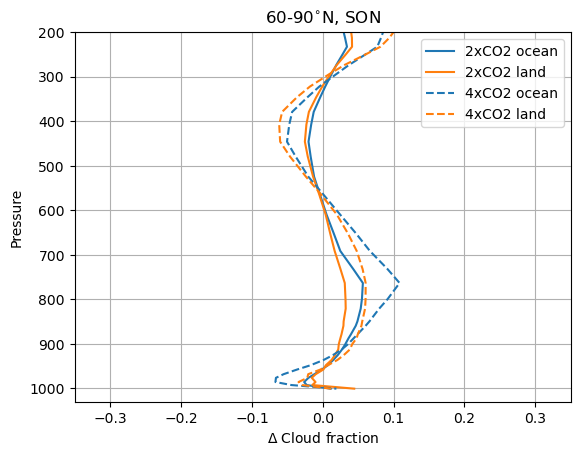

In [63]:
var = 'CLOUD'
season = 'SON'
Arctic_limit = 60

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))


plt.plot(Arctic_ocn_2xCO2-Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', label='2xCO2 ocean')
plt.plot(Arctic_lnd_2xCO2-Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', label='2xCO2 land')
plt.plot(Arctic_ocn_4xCO2-Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
plt.plot(Arctic_lnd_4xCO2-Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('$\Delta$ Cloud fraction')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([-0.35, 0.35])
plt.grid()
plt.show()

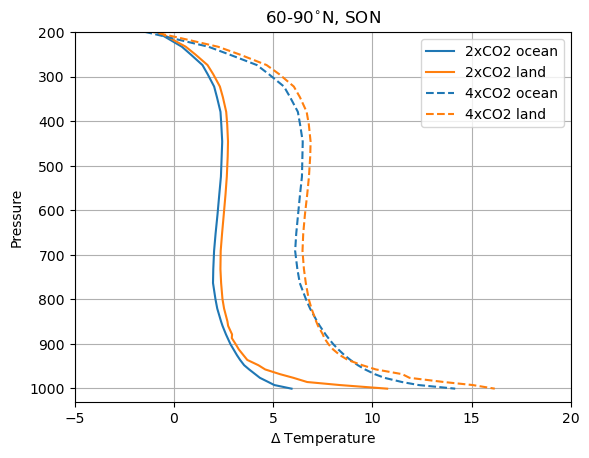

In [66]:
var = 'T'
season = 'SON'
Arctic_limit = 60

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))


plt.plot(Arctic_ocn_2xCO2-Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', label='2xCO2 ocean')
plt.plot(Arctic_lnd_2xCO2-Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', label='2xCO2 land')
plt.plot(Arctic_ocn_4xCO2-Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
plt.plot(Arctic_lnd_4xCO2-Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('$\Delta$ Temperature')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([-5, 20])
plt.grid()
plt.show()

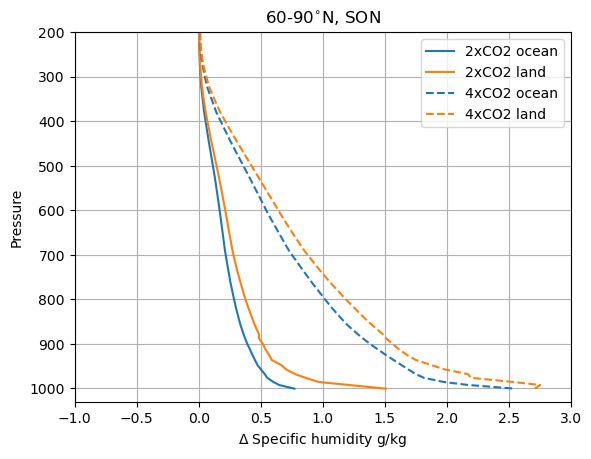

In [14]:
var = 'Q'
season = 'SON'
Arctic_limit = 60

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))


plt.plot((Arctic_ocn_2xCO2-Arctic_ocn_piClim)*1000, ds_seasons.plev, color='tab:blue', label='2xCO2 ocean')
plt.plot((Arctic_lnd_2xCO2-Arctic_lnd_piClim)*1000, ds_seasons.plev, color='tab:orange', label='2xCO2 land')
plt.plot((Arctic_ocn_4xCO2-Arctic_ocn_piClim)*1000, ds_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
plt.plot((Arctic_lnd_4xCO2-Arctic_lnd_piClim)*1000, ds_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('$\Delta$ Specific humidity g/kg')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([-1, 3])
plt.grid()
plt.show()

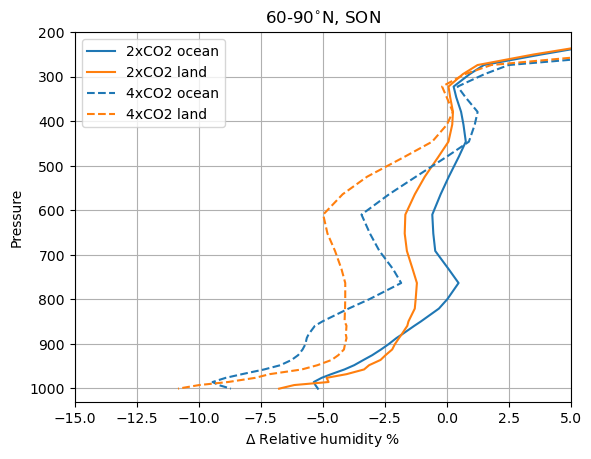

In [15]:
var = 'RELHUM'
season = 'SON'
Arctic_limit = 60

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))


plt.plot((Arctic_ocn_2xCO2-Arctic_ocn_piClim), ds_seasons.plev, color='tab:blue', label='2xCO2 ocean')
plt.plot((Arctic_lnd_2xCO2-Arctic_lnd_piClim), ds_seasons.plev, color='tab:orange', label='2xCO2 land')
plt.plot((Arctic_ocn_4xCO2-Arctic_ocn_piClim), ds_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
plt.plot((Arctic_lnd_4xCO2-Arctic_lnd_piClim), ds_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('$\Delta$ Relative humidity %')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([-15, 5])
plt.grid()
plt.show()

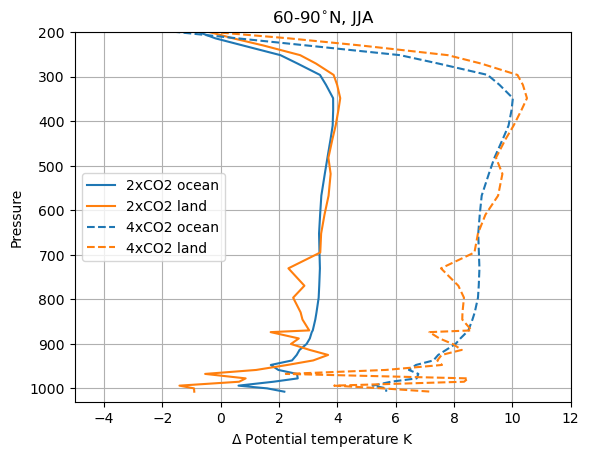

In [19]:
var = 'TH'
season = 'JJA'
Arctic_limit = 60

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))


plt.plot((Arctic_ocn_2xCO2-Arctic_ocn_piClim), ds_if_seasons.plev, color='tab:blue', label='2xCO2 ocean')
plt.plot((Arctic_lnd_2xCO2-Arctic_lnd_piClim), ds_if_seasons.plev, color='tab:orange', label='2xCO2 land')
plt.plot((Arctic_ocn_4xCO2-Arctic_ocn_piClim), ds_if_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
plt.plot((Arctic_lnd_4xCO2-Arctic_lnd_piClim), ds_if_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('$\Delta$ Potential temperature K')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([-5, 12])
plt.grid()
plt.show()


## Create absolute profiles

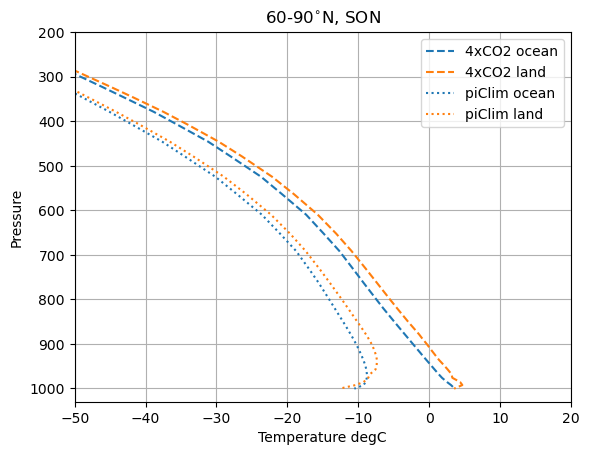

In [71]:
var = 'T'
season = 'SON'
Arctic_limit = 60

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))

plt.plot(Arctic_ocn_4xCO2-273.15, ds_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
plt.plot(Arctic_lnd_4xCO2-273.15, ds_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.plot(Arctic_ocn_piClim-273.15, ds_seasons.plev, color='tab:blue', linestyle = ':',label='piClim ocean')
plt.plot(Arctic_lnd_piClim-273.15, ds_seasons.plev, color='tab:orange', linestyle = ':', label='piClim land')


plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('Temperature degC')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([-50, 20])
plt.grid()
plt.show()

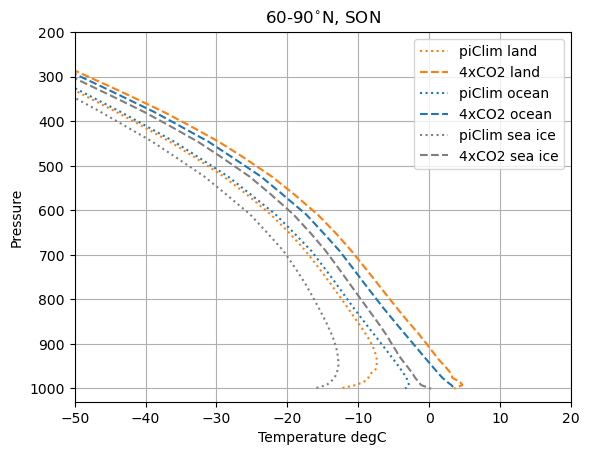

In [ ]:
var = 'T'
season = 'SON'
Arctic_limit = 60
ice_ocn_divide = True

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))

if ice_ocn_divide:
    Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), openocean_piClim.sel(lat=slice(Arctic_limit, 90), season=season))
    Arctic_ice_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), icemask_piClim.sel(lat=slice(Arctic_limit, 90), season=season))
    Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), openocean_4xCO2.sel(lat=slice(Arctic_limit, 90), season=season))
    Arctic_ice_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), icemask_4xCO2.sel(lat=slice(Arctic_limit, 90), season=season))
else:
    Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))
    Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))

plt.plot(Arctic_lnd_piClim-273.15, ds_seasons.plev, color='tab:orange', linestyle = ':', label='piClim land')
plt.plot(Arctic_lnd_4xCO2-273.15, ds_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.plot(Arctic_ocn_piClim-273.15, ds_seasons.plev, color='tab:blue', linestyle = ':',label='piClim ocean')
plt.plot(Arctic_ocn_4xCO2-273.15, ds_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
if ice_ocn_divide:
    plt.plot(Arctic_ice_piClim-273.15, ds_seasons.plev, color='tab:grey', linestyle = ':',label='piClim sea ice')
    plt.plot(Arctic_ice_4xCO2-273.15, ds_seasons.plev, color='tab:grey', linestyle = '--',label='4xCO2 sea ice')

plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('Temperature degC')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([-50, 20])
plt.grid()
plt.show()

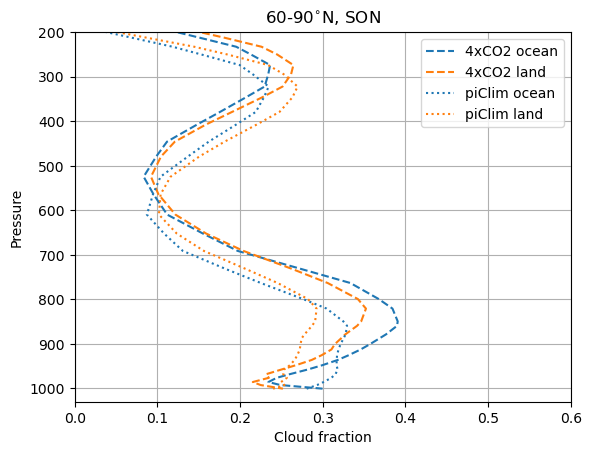

In [69]:
var = 'CLOUD'
season = 'SON'
Arctic_limit = 60

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))


plt.plot(Arctic_ocn_4xCO2, ds_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
plt.plot(Arctic_lnd_4xCO2, ds_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.plot(Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', linestyle = ':',label='piClim ocean')
plt.plot(Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', linestyle = ':', label='piClim land')

plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('Cloud fraction')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([0, 0.6])
plt.grid()
plt.show()

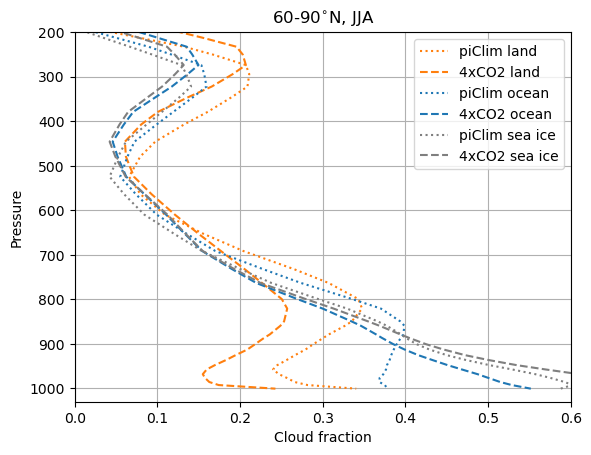

In [15]:
var = 'CLOUD'
season = 'JJA'
Arctic_limit = 60
ice_ocn_divide = True

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))

if ice_ocn_divide:
    Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), openocean_piClim.sel(lat=slice(Arctic_limit, 90), season=season))
    Arctic_ice_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), icemask_piClim.sel(lat=slice(Arctic_limit, 90), season=season))
    Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), openocean_4xCO2.sel(lat=slice(Arctic_limit, 90), season=season))
    Arctic_ice_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), icemask_4xCO2.sel(lat=slice(Arctic_limit, 90), season=season))
else:
    Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))
    Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))

plt.plot(Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', linestyle = ':', label='piClim land')
plt.plot(Arctic_lnd_4xCO2, ds_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.plot(Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', linestyle = ':',label='piClim ocean')
plt.plot(Arctic_ocn_4xCO2, ds_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
if ice_ocn_divide:
    plt.plot(Arctic_ice_piClim, ds_seasons.plev, color='tab:grey', linestyle = ':',label='piClim sea ice')
    plt.plot(Arctic_ice_4xCO2, ds_seasons.plev, color='tab:grey', linestyle = '--',label='4xCO2 sea ice')

plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('Cloud fraction')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([0, 0.6])
plt.grid()
plt.show()

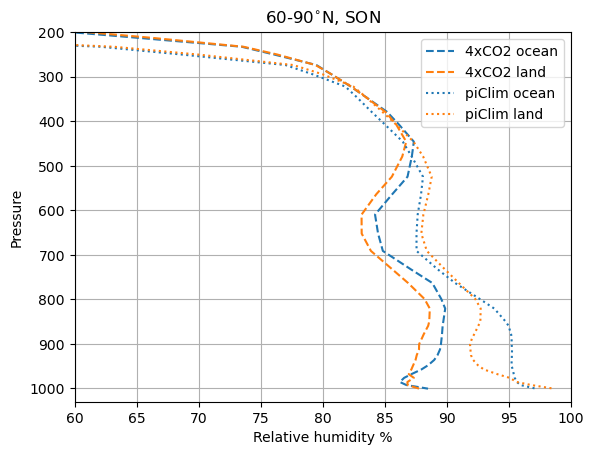

In [72]:
var = 'RELHUM'
season = 'SON'
Arctic_limit = 60

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))


plt.plot(Arctic_ocn_4xCO2, ds_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
plt.plot(Arctic_lnd_4xCO2, ds_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.plot(Arctic_ocn_piClim, ds_seasons.plev, color='tab:blue', linestyle = ':',label='piClim ocean')
plt.plot(Arctic_lnd_piClim, ds_seasons.plev, color='tab:orange', linestyle = ':', label='piClim land')

plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('Relative humidity %')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([60, 100])
plt.grid()
plt.show()

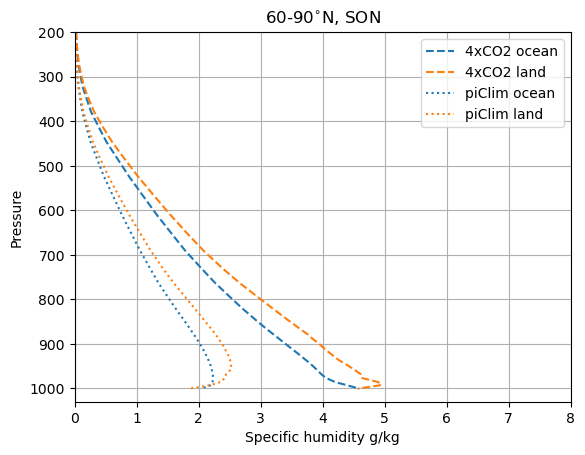

In [78]:
var = 'Q'
season = 'SON'
Arctic_limit = 60

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))


plt.plot(Arctic_ocn_4xCO2*1000, ds_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
plt.plot(Arctic_lnd_4xCO2*1000, ds_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.plot(Arctic_ocn_piClim*1000, ds_seasons.plev, color='tab:blue', linestyle = ':',label='piClim ocean')
plt.plot(Arctic_lnd_piClim*1000, ds_seasons.plev, color='tab:orange', linestyle = ':', label='piClim land')

plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('Specific humidity g/kg')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([0,8])
plt.grid()
plt.show()

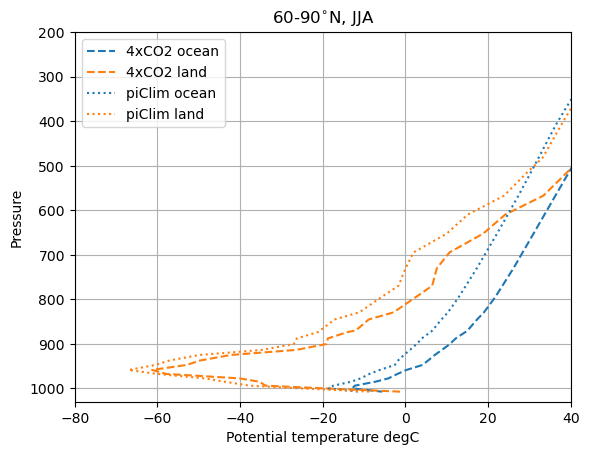

In [27]:
var = 'TH'
season = 'JJA'
Arctic_limit = 60

Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=0), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=1), oceanmask.sel(lat=slice(Arctic_limit, 90)))

Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), landmask.sel(lat=slice(Arctic_limit, 90)))
Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_if_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc=2), oceanmask.sel(lat=slice(Arctic_limit, 90)))


plt.plot(Arctic_ocn_4xCO2-273.15, ds_if_seasons.plev, color='tab:blue', linestyle = '--',label='4xCO2 ocean')
plt.plot(Arctic_lnd_4xCO2-273.15, ds_if_seasons.plev, color='tab:orange', linestyle = '--', label='4xCO2 land')
plt.plot(Arctic_ocn_piClim-273.15, ds_if_seasons.plev, color='tab:blue', linestyle = ':',label='piClim ocean')
plt.plot(Arctic_lnd_piClim-273.15, ds_if_seasons.plev, color='tab:orange', linestyle = ':', label='piClim land')

plt.legend()
plt.ylim([1030,200])
plt.ylabel('Pressure')
plt.xlabel('Potential temperature degC')
plt.title(str(Arctic_lim)+'-90$^{\circ}$N, '+season)
plt.xlim([-80, 40])
plt.grid()
plt.show()